# ***Import Necessary Libraries***

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report,silhouette_score
from time import time
import string
import re
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read the dataset
df = pd.read_csv('cyber_labelled.csv')

In [3]:
df.head()

,label,full_text
0,1,So Drasko just said he was impressed the girls...
1,1,Drasko they didn't cook half a bird you idiot ...
2,1,Hopefully someone cooks Drasko in the next ep ...
3,1,of course you were born in serbia...you're as ...
4,1,These girls are the equivalent of the irritati...


In [4]:
df['classification']=df['label'].replace(1,'Bullying')
df['classification']=df['classification'].replace(0,'Non-Bullying')
df

,label,full_text,classification
0,1,So Drasko just said he was impressed the girls...,Bullying
1,1,Drasko they didn't cook half a bird you idiot ...,Bullying
2,1,Hopefully someone cooks Drasko in the next ep ...,Bullying
3,1,of course you were born in serbia...you're as ...,Bullying
4,1,These girls are the equivalent of the irritati...,Bullying
...,...,...,...
35782,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,Bullying
35783,0,"you've gone and broke the wrong heart baby, an...",Non-Bullying
35784,1,young buck wanna eat!!.. dat nigguh like I ain...,Bullying
35785,1,youu got wild bitches tellin you lies,Bullying


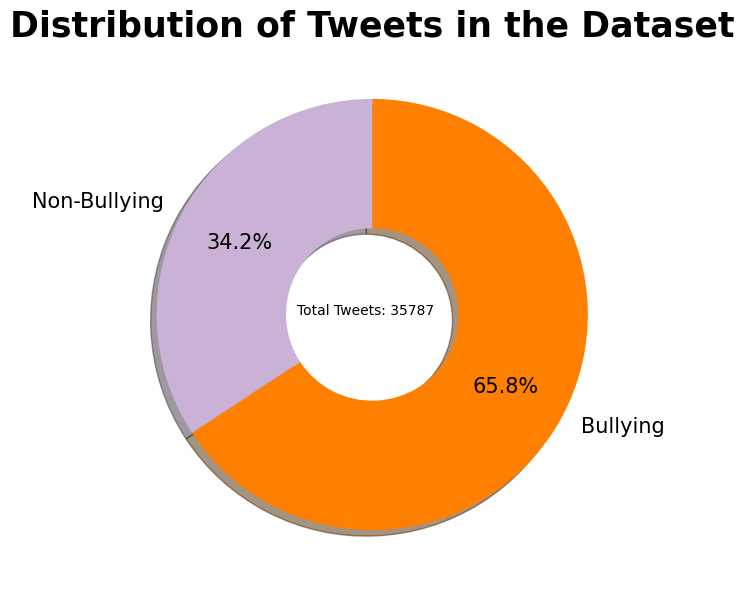

In [5]:
plt.figure(figsize = (7,7))
sorted_counts = df['classification'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontweight= 'bold', fontsize = 25);

In [6]:
def removeSpecialCharacter(v):
    text = "".join([r for r in v if ('A' <= r <= 'Z') or ('a' <= r <= 'z') or (r == " ")])
    return text

In [7]:
df['full_text']= df['full_text'].apply(lambda x: removeSpecialCharacter (str(x)))
df['full_text'].replace('', np.nan, inplace=True)

# ***Splitting the dataset into Train and Test data***

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'], 
                                                    df['label'], 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 35787
Number of rows in the training set: 26840
Number of rows in the test set: 8947


# ***PREPROCESSING***

In [9]:
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)
def remove_punct(text):
    text="".join([char for char in text if char not in string.punctuation])
    text=re.sub('[0-9]+','',text)
    return text
df['full_text']=df['full_text'].apply(lambda x: remove_punct(x))
def tokenization(text):
    text=re.split('\W+',text)
    return text
df['full_text']=df['full_text'].apply(lambda x: tokenization(x.lower()))
ps = nltk.PorterStemmer()
def stemming(text):
    text=[ps.stem(word) for word in text]
    return text
df['full_text']=df['full_text'].apply(lambda x: stemming(x))
df.head(10)
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

In [10]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    
    size = len(y_train)
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        results['Algorithm'] = learner.__class__.__name__
        start = time() 
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time()

        results['Training Time'] = end - start
        start = time() 
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time()

        results['Prediction Time'] = end - start

        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        results['Precision: Test'] = precision_score(y_test, predictions_test)

        results['Precision: Train'] = precision_score(y_train, predictions_train)

        results['Recall: Test'] = recall_score(y_test, predictions_test)

        results['Recall: Train'] = recall_score(y_train, predictions_train)
        
        results['Confusion Matrix: Test'] = confusion_matrix(y_test, predictions_test)
        
        results['Confusion Matrix: Train'] = confusion_matrix(y_train, predictions_train)

        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('__________________________________________________________')
        
        final_results.append(results.copy())

    return final_results

# ***Supervised Learning Models***

In [11]:
models = [SGDClassifier(), LinearSVC(),AdaBoostClassifier(),
          LogisticRegression(), MultinomialNB(), KNeighborsClassifier()]

In [12]:
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time', 'Confusion Matrix: Test', 'Confusion Matrix: Train'])

Training SGDClassifier
Training SGDClassifier finished in 0.33 sec
__________________________________________________________
Training LinearSVC
Training LinearSVC finished in 1.44 sec
__________________________________________________________
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 6.70 sec
__________________________________________________________
Training LogisticRegression
Training LogisticRegression finished in 3.35 sec
__________________________________________________________
Training MultinomialNB
Training MultinomialNB finished in 0.02 sec
__________________________________________________________
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.00 sec
__________________________________________________________


In [13]:
results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time,Confusion Matrix: Test,Confusion Matrix: Train
0,LogisticRegression,0.922209,0.965016,0.914796,0.939235,0.002776,0.978353,0.990067,0.976885,0.983432,3.354540,"[[2872, 195], [501, 5379]]","[[9016, 173], [408, 17243]]"
1,SGDClassifier,0.920867,0.960798,0.917007,0.938392,0.004170,0.982154,0.991865,0.980908,0.986356,0.329388,"[[2847, 220], [488, 5392]]","[[9047, 142], [337, 17314]]"
2,LinearSVC,0.913155,0.948025,0.918197,0.932873,0.003370,0.997057,0.998468,0.997054,0.997761,1.441831,"[[2771, 296], [481, 5399]]","[[9162, 27], [52, 17599]]"
3,AdaBoostClassifier,0.898961,0.969789,0.873469,0.919112,0.770377,0.900745,0.969135,0.877004,0.920771,6.700979,"[[2907, 160], [744, 5136]]","[[8696, 493], [2171, 15480]]"
4,MultinomialNB,0.890019,0.893190,0.945748,0.918718,0.007060,0.948398,0.957013,0.964875,0.960928,0.022261,"[[2402, 665], [319, 5561]]","[[8424, 765], [620, 17031]]"
5,KNeighborsClassifier,0.842182,0.861021,0.906122,0.882996,32.451682,0.890909,0.899539,0.938984,0.918838,0.004153,"[[2207, 860], [552, 5328]]","[[7338, 1851], [1077, 16574]]"


In [14]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.842182,0.861021,0.873469,0.882996,0.002776,0.890909,0.899539,0.877004,0.918838,0.004153
max,0.922209,0.969789,0.945748,0.939235,32.451682,0.997057,0.998468,0.997054,0.997761,6.700979


In [15]:
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

# ***Plot For Comparing Models***

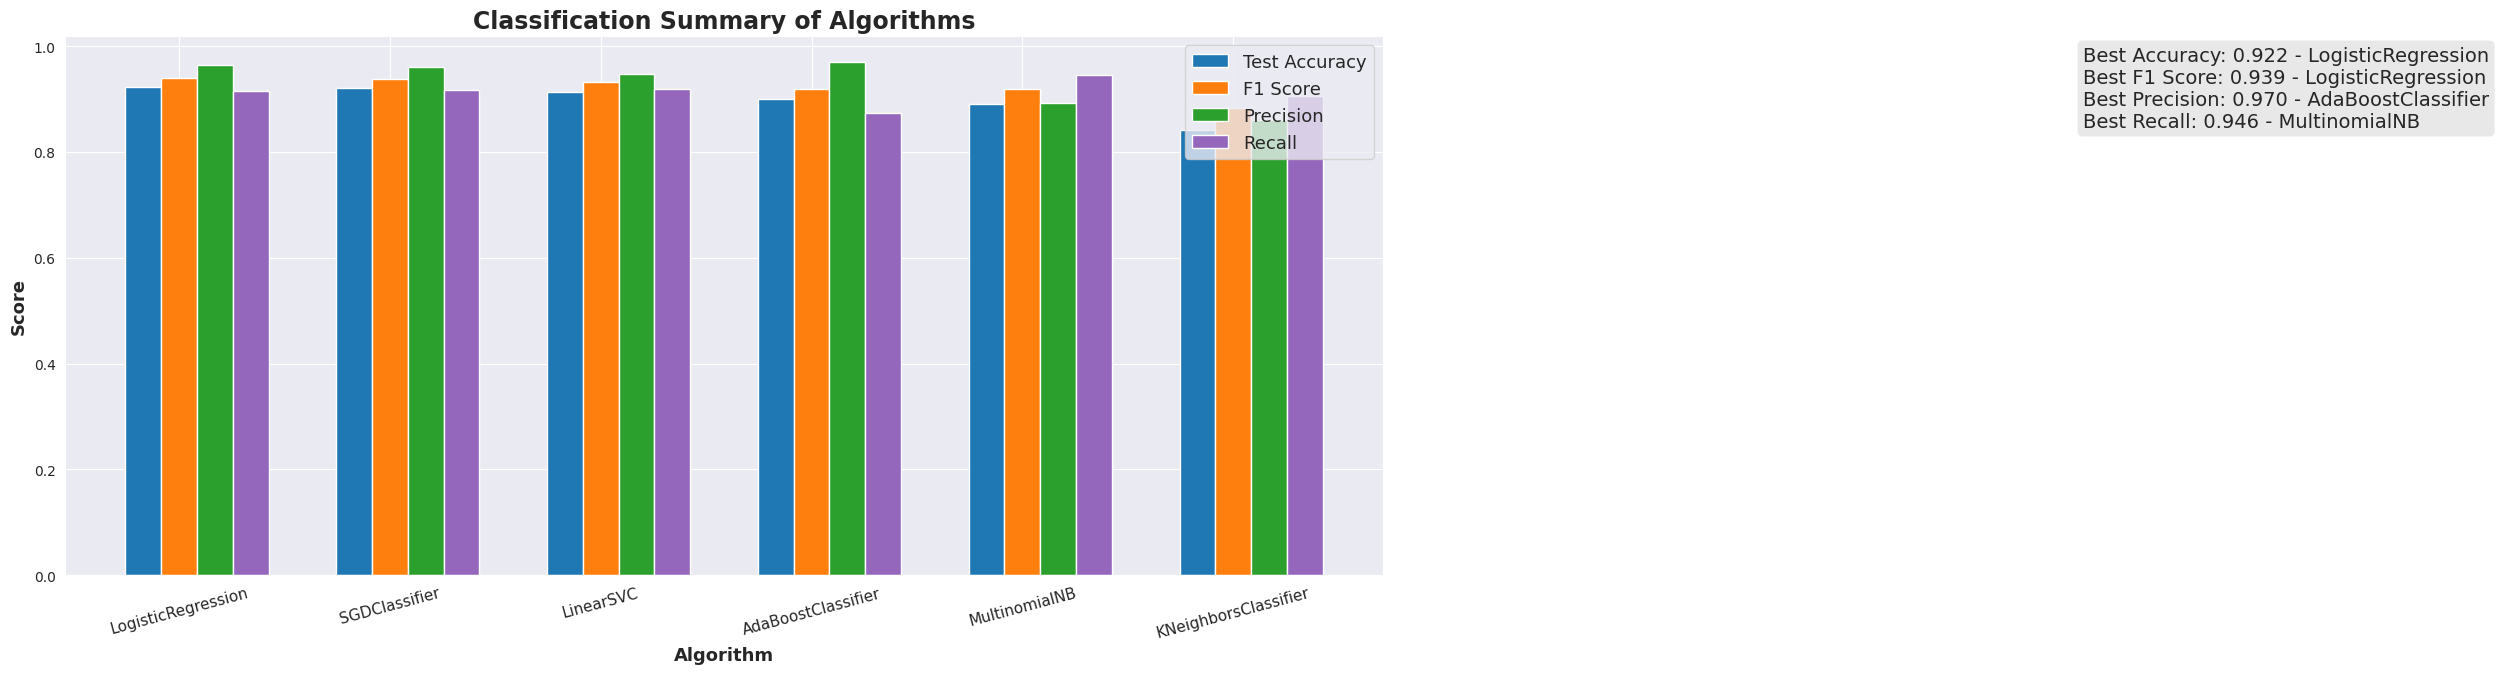

In [16]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))
barWidth = 0.17

bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [17]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

# ***Plot For Time Complexities***

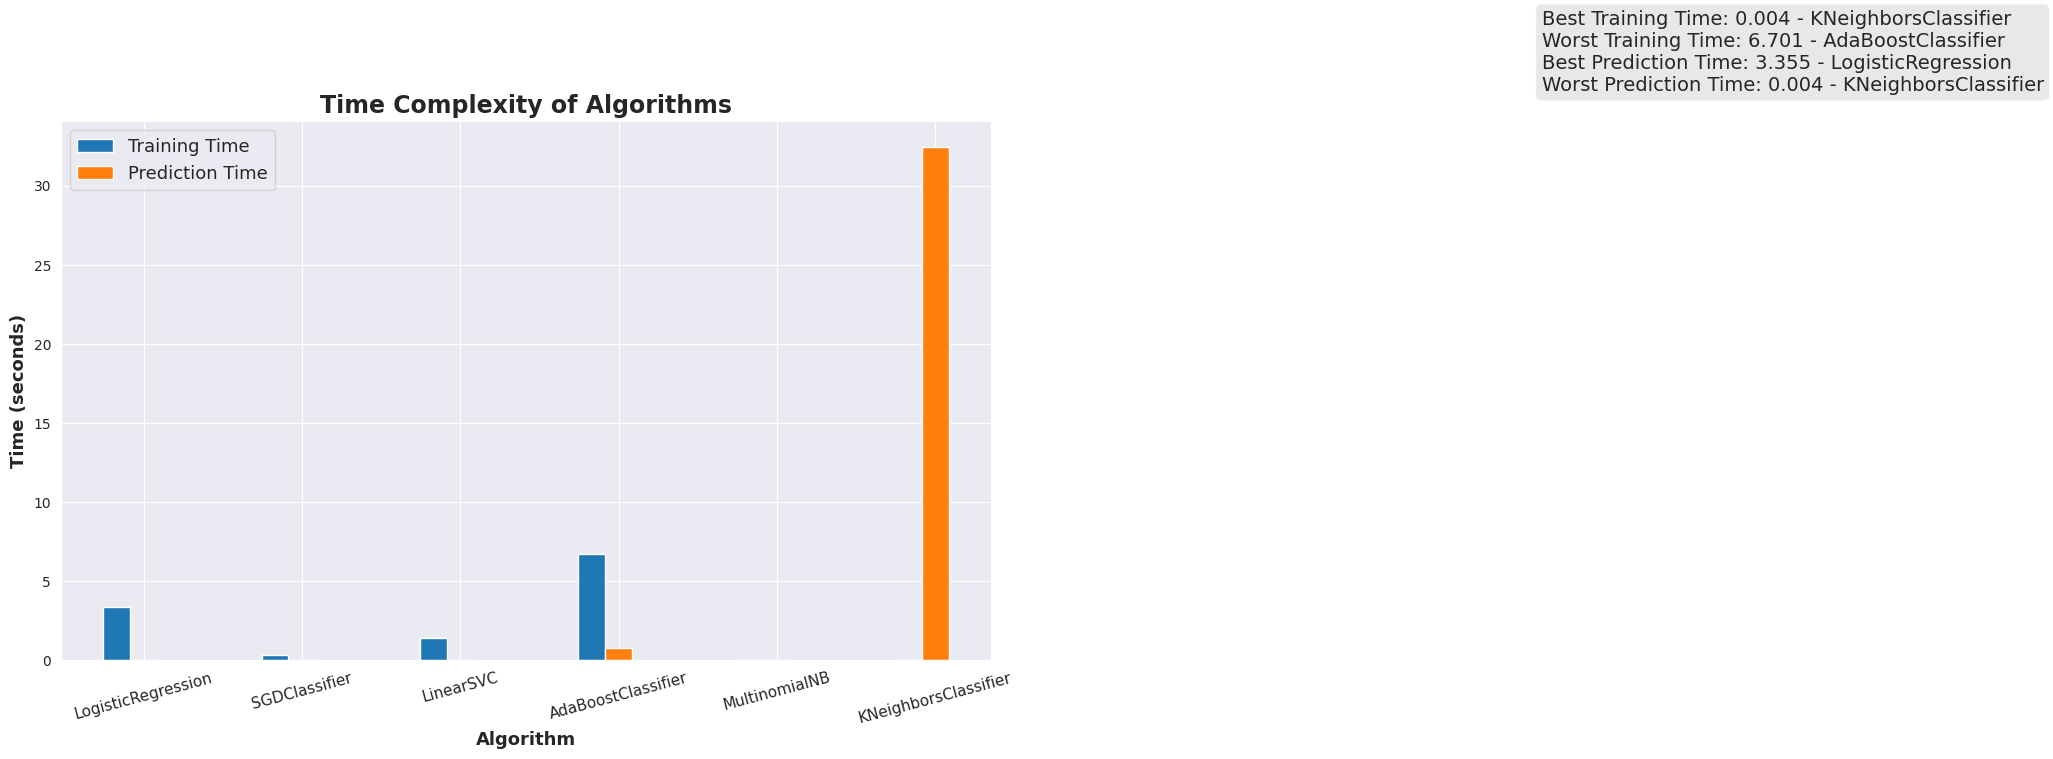

In [18]:
plt.figure(figsize = (12, 7))

barWidth = 0.17

bars1 = results['Training Time']
bars2 = results['Prediction Time']

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')

plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

# ***K-Means Clustering Using Labelled Dataset*** 

In [19]:
#read the labelled dataset
dp = pd.read_csv('cyber_labelled.csv')

In [20]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(dp['full_text'])

In [21]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans_labels = kmeans.labels_

In [37]:
print("K-means clustering performance:")
print("Confusion Matrix:",confusion_matrix(kmeans_labels, dp['label']))
print(classification_report(kmeans_labels, dp['label']))

K-means clustering performance:
Confusion Matrix: [[   55   876]
 [12201 22655]]
              precision    recall  f1-score   support

           0       0.00      0.06      0.01       931
           1       0.96      0.65      0.78     34856

    accuracy                           0.63     35787
   macro avg       0.48      0.35      0.39     35787
weighted avg       0.94      0.63      0.76     35787



In [23]:
accuracy = accuracy_score(kmeans_labels, dp['label'])

Text(0.5, 1.0, 'K-means clustering metrics')

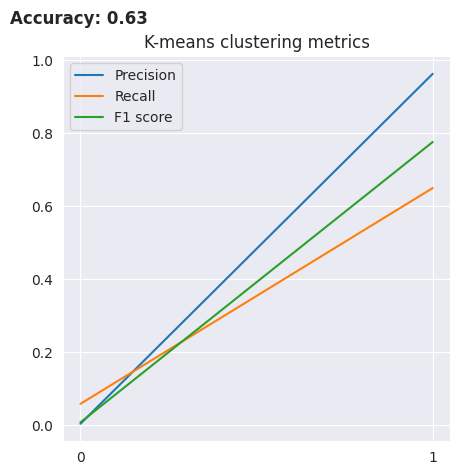

In [24]:
#plot for Metrics
kmeans_metrics = classification_report(kmeans_labels, dp['label'], output_dict=True)
precision = [kmeans_metrics[str(i)]['precision'] for i in range(2)]
recall = [kmeans_metrics[str(i)]['recall'] for i in range(2)]
f1_score = [kmeans_metrics[str(i)]['f1-score'] for i in range(2)]
plt.figure(figsize=(5, 5))
plt.plot(['0', '1'], precision, label='Precision')
plt.plot(['0', '1'], recall, label='Recall')
plt.plot(['0', '1'], f1_score, label='F1 score')
plt.text(-0.2, 1.1, 'Accuracy: {:.2f}'.format(accuracy), fontsize=12, fontweight='bold')
plt.legend()
plt.title('K-means clustering metrics')

# ***K-Means Clustering Using Unlabelled Dataset***

In [25]:
#read the Unlabelled dataset
data = pd.read_csv("cyber_unlabelled.csv")
data

,full_text
0,"['so', 'drasko', 'just', 'said', 'he', 'wa', '..."
1,"['drasko', 'they', 'didnt', 'cook', 'half', 'a..."
2,"['hope', 'someon', 'cook', 'drasko', 'in', 'th..."
3,"['of', 'cours', 'you', 'were', 'born', 'in', '..."
4,"['these', 'girl', 'are', 'the', 'equival', 'of..."
...,...
35782,"['you', 'a', 'muthafin', 'lie', 'lifeask', 'pe..."
35783,"['youv', 'gone', 'and', 'broke', 'the', 'wrong..."
35784,"['young', 'buck', 'wanna', 'eat', 'dat', 'nigg..."
35785,"['youu', 'got', 'wild', 'bitch', 'tellin', 'yo..."


In [26]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data["full_text"])

In [27]:
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X)

In [28]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels = kmeans.labels_

# ***Silhouette Coefficient***
## If silhouette coefficient is near to "1" clustering is done good, if it is near to "0" clustering is done bad and there is overlapping

In [29]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.005


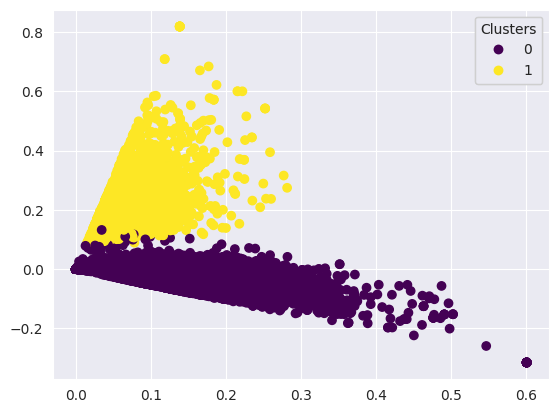

In [30]:
#plotting based on clusters
fig, ax = plt.subplots()
scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.show()

# ***Creating Interface Using Gradio***

In [31]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import gradio as gr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [33]:
# choose the method with best results as classifier
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()
vectorizer.fit(X_train)
classifier.fit(vectorizer.transform(X_train), y_train)

LogisticRegression()

In [34]:
def predict_comment(comment):
    prediction = classifier.predict(vectorizer.transform([comment]))[0]
    if prediction == 0:
        return "Non-Bullying"
    else:
        return "Bullying"

In [35]:
iface = gr.Interface(
    fn=predict_comment,
    inputs=gr.inputs.Textbox(label="Enter message"),
    outputs="label",
    title="Cyber Bullying Classification",
    description="Enter a message to see whether it is bullying or non_bullying.",
    theme="compact"
)

In [36]:
iface.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>